In [1]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
sns.set()
# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'#cccccc'})
%matplotlib auto
from PIL import Image
import pandas as pd

Using matplotlib backend: Qt5Agg


In [2]:
df = pd.read_excel('cvals.xlsx')

In [3]:
df.head()

,ill,vp,wb,sq,r,g,b
0,1,1,0.0,w,186.0,188,216
1,1,1,NaN,m,189.0,95,128
2,1,1,NaN,c,18.0,132,173
3,1,1,NaN,y,206.0,195,136
4,1,2,NaN,w,178.0,183,217


In [65]:
# white points for each illuminant
# D * rawPicture = fixed picture
def getDByWhitePatch(df, ill):
    illDf = df[df.ill == ill ]
    illDf = illDf[illDf.sq == 'w']
    sumR = illDf.r.sum()
    sumG = illDf.g.sum()
    sumB = illDf.b.sum()
    R = sumR / illDf.shape[0]
    G = sumG / illDf.shape[0]
    B = sumB / illDf.shape[0]
    
    # we got the RGB in white. Fixed images have 255, 255, 255 for all the channels.
    D = np.zeros([3, 3])
    
    D[0, 0] = 255 / R
    D[1, 1] = 255 / G
    D[2, 2] = 255 / B
    
    return D

def getDByGrayWorld(df, ill):
    # gray world has rgb(128,128,128)
    illDf = df[df.ill == ill ]
    sumR = illDf.r.sum()
    sumG = illDf.g.sum()
    sumB = illDf.b.sum()
    R = sumR / illDf.shape[0]
    G = sumG / illDf.shape[0]
    B = sumB / illDf.shape[0]
    
    # we got the RGB in white. Fixed images have rgb(128,128,128) for all the channels.
    D = np.zeros([3, 3])
    
    D[0, 0] = 128 / R
    D[1, 1] = 128 / G
    D[2, 2] = 128 / B
    
    return D


def getMaxRGB(df):
    
    r, g, b = 0, 0 ,0 # holds values for maxBrightness color
    maxBrightness = 0
    
    for row in df.itertuples():
        brightness = row.r + row.g + row.b 
        if brightness > maxBrightness: 
            maxBrightness = brightness
            r = row.r
            g = row.g
            b = row.b
    
    return r, g, b
        
    
def getDByWhiteWorld(df, ill):
    # gray world has rgb(128,128,128)
    illDf = df[df.ill == ill ]
    
    R, G, B = getMaxRGB(illDf)
    
    print(f'R: {R}, G: {G}, B: {B}')
    
    # we got the RGB in white. Fixed images have rgb(128,128,128) for all the channels.
    D = np.zeros([3, 3])
    
    D[0, 0] = 255 / R
    D[1, 1] = 255 / G
    D[2, 2] = 255 / B
    
    return D
    

# def fixRowByD(row):
#     print(row)
    
#     row.r = row.r * D[0, 0]
#     row.g = row.g * D[1, 1]
#     row.b = row.b * D[2, 2]
#     return row
    
    
def fixColorsByD(df, ill, D):
    
#     df.transform(fixRowByD, axis = 1)
#     df.loc[df[ill] == ill, 'r'] = 
    for index, row in df.iterrows():
#         print(row)
        if row.ill == ill:
            df.at[index, 'r'] = row.r * D[0, 0]
            df.at[index, 'g']  = row.g * D[1, 1]
            df.at[index, 'b']  = row.b * D[2, 2]
    
    pass
    
    

In [47]:
D1_WP = getDByWhitePatch(df, 1)
D2_WP = getDByWhitePatch(df, 2)
D3_WP = getDByWhitePatch(df, 3)

D1_GW = getDByGrayWorld(df, 1)
D2_GW = getDByGrayWorld(df, 2)
D3_GW = getDByGrayWorld(df, 3)

D1_WW = getDByWhiteWorld(df, 1)
D2_WW = getDByWhiteWorld(df, 2)
D3_WW = getDByWhiteWorld(df, 3)

R: 195.0, G: 196, B: 224
R: 179.0, G: 198, B: 238
R: 151.0, G: 204, B: 253


In [48]:
D1_WP

array([[1.37096774, 0.        , 0.        ],
       [0.        , 1.34351949, 0.        ],
       [0.        , 0.        , 1.15803815]])

In [49]:
D1_GW

array([[0.83344185, 0.        , 0.        ],
       [0.        , 0.7992507 , 0.        ],
       [0.        , 0.        , 0.73247496]])

In [50]:
D1_WW

array([[1.30769231, 0.        , 0.        ],
       [0.        , 1.30102041, 0.        ],
       [0.        , 0.        , 1.13839286]])

In [51]:
# # normalize values.
def normalizeRows(row):
    total = row.r + row.g + row.b
    row.r = row.r / total
    row.g = row.g / total
    row.b = row.b / total
#     print(row.sq)
    if row.sq == 'w':
        row.sq = 'white'
    elif row.sq == 'c':
        row.sq = 'cyan'
    elif row.sq == 'm':
        row.sq = 'magenta'
    else:
        row.sq = 'yellow'
#     print(row.sq)
        
    return row

In [71]:
df = pd.read_excel('cvals.xlsx')
fixColorsByD(df, 1, D1_WP)
fixColorsByD(df, 2, D2_WP)
fixColorsByD(df, 3, D3_WP)
df = df.transform(normalizeRows, axis=1)

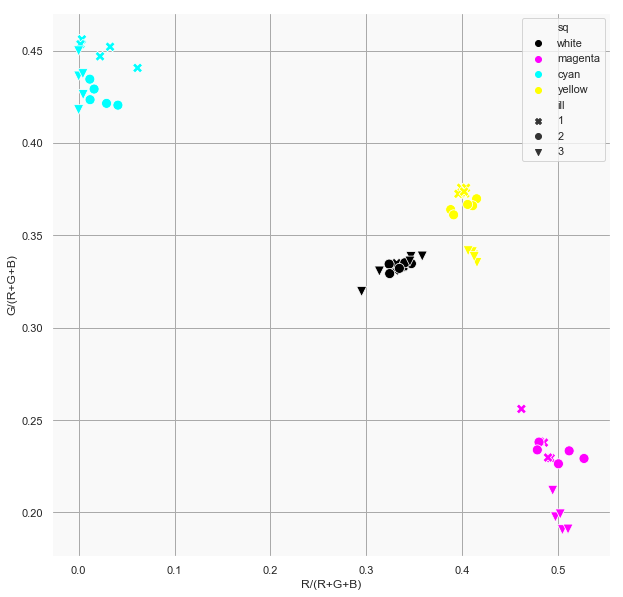

In [72]:
plt.figure(figsize=(10, 10))
plt.rcParams['axes.facecolor'] = '#f9f9f9'
plt.grid(color='#aaaaaa')
palette = {'white':'black', 'magenta':'magenta', 'yellow': 'yellow', 'cyan': 'cyan'}
ax = sns.scatterplot(df.r, df.g,  style=df.ill, hue=df.sq, markers={1:'X', 2:'o', 3:'v'}, palette=palette, s=100)
# plt.xlabel = 'R/(R+G+B)'
ax.set(xlabel='R/(R+G+B)', ylabel='G/(R+G+B)')
plt.show()

In [55]:
df.r = df.r * 10
df

,ill,vp,wb,sq,r,g,b
0,1,1,0.0,white,3.152542,0.318644,0.366102
1,1,1,NaN,magenta,4.587379,0.230583,0.310680
2,1,1,NaN,cyan,0.557276,0.408669,0.535604
3,1,1,NaN,yellow,3.836127,0.363128,0.253259
4,1,2,NaN,white,3.079585,0.316609,0.375433
5,1,2,NaN,magenta,4.545455,0.230444,0.315011
6,1,2,NaN,cyan,0.030581,0.418960,0.577982
7,1,2,NaN,yellow,3.800000,0.365455,0.254545
8,1,3,NaN,white,3.170732,0.318699,0.364228
9,1,3,NaN,magenta,4.357430,0.246988,0.317269
